# 15分钟跑通你的第一个few-shot代码

我已经研究了一段时间的小样本分类了。我说得越多，我周围的人似乎越觉得这是某种黑魔法。更可悲的是:我注意到很少有人在他们的项目中使用它。我认为这太糟糕了，所以我决定做一个教程。

在15分钟和几行代码中，我们将实现[Prototypical Networks](https://arxiv.org/abs/1703.05175). 这是许多学习研究人员最喜欢的方法(3年内约有2000次引用)，因为 1)它很有效，2)它非常容易掌握和实施。

## 探索原型网络

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

现在我们需要搞个数据集. 我建议我们使用 [Omniglot](https://github.com/brendenlake/omniglot), 一种流行的类似mnist的one-shot分类基准。它包含来自50个不同字母的1623个字符。每个字都是由20个不同的人写的
好处:他是`torchivision`包的一部分，不用你下载了

In [2]:
image_size = 28

# NB: background=True选择训练集，background=False选择测试集
# 这是原文中的命名法，我们只需要处理它

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data\omniglot-py\images_background.zip to ./data\omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data\omniglot-py\images_evaluation.zip to ./data\omniglot-py


让我们花点时间来理解什么是小样本分类。简单来说，在一个小样本分类任务中，你有一个标记过的支持集（它有点像一个目录）和查询集。对于查询集中的每一张图片，我们想要从支持集中存在的标签中预测一个标签。一个小样本分类模型必须使用来自支持集的信息来对查询图片进行分类。当支持集对于每个标签只包含非常少的图片（通常少于10张）时，我们称之为*小样本*。下面的图展示了一个3类2样本的分类任务。“3类”意味着“3个不同的类别”，“2样本”意味着“每个类别2个例子”。我们期望一个模型，在其训练过程中从未见过任何圣伯纳德犬、巴哥犬或拉布拉多犬，能成功地预测查询标签。支持集是模型关于什么是圣伯纳德犬、巴哥犬或拉布拉多犬的唯一信息。

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

大多数小样本分类方法都是*基于度量的*。它分为两个阶段：

1）它们使用CNN将支持和查询图像投影到一个特征空间中，以及

2）通过将查询图像与支持图像进行比较来分类查询图像。如果在特征空间中，一张图像更接近巴哥犬而不是拉布拉多犬和圣伯纳德犬，我们会猜测它是一只巴哥犬。

从这里，我们有两个挑战：

1. 找到好的特征空间。这就是卷积网络的用途。一个CNN基本上是一个函数，它将图像作为输入，并输出这个图像在给定特征空间中的表示（或*嵌入*）。这里的挑战是拥有一个CNN，它会将同一个类别的图像投影到彼此接近的表示中，即使它没有在这个类别的对象上进行训练。
2. 找到一种好的方式来比较特征空间中的表示。这是原型网络的工作。
![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

从支持集出发，原型网络为每个类计算一个原型，这个原型是该类中所有支持图像的嵌入的平均值。然后，每个查询简单地被分类为特征空间中最近的原型，关于欧几里得距离。

如果你想了解更多关于这是如何工作的，我解释它
[这里](https://www.sicara.fr/blog-technique/few-shot-image-classification-meta-learning).
但现在，让我们开始编码。
在下面的代码中（修改自[这里](https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/methods/prototypical_networks.py)），我们简单地将原型网络定义为一个torch模块，带有一个`forward()`方法。
你可能会注意到两件事。

1. 我们使用一个*骨干网络*来初始化`PrototypicalNetworks`。这就是我们之前提到的特征提取器。在这里，我们使用预训练在ImageNet上的ResNet18作为骨干网络，将其头部去掉并替换为一个`Flatten`层。对于输入图像，骨干网络的输出将是一个512维的特征向量。
2. `forward`方法不仅接收一个输入张量，而是接收三个：为了预测查询图像的标签，我们还需要支持图像和标签作为模型的输入。

这段代码是原型网络（Prototypical Networks）的一部分，它的作用是从支持集（support set）和查询集（query set）中提取特征，并基于支持集的标签计算每个类的原型。让我们逐步解释这段代码的操作：

1. `z_support = self.backbone.forward(support_images)`：这一行使用模型的骨干网络（backbone）对支持集中的图像进行特征提取。`support_images`是支持集中的图像，`z_support`是这些图像通过骨干网络提取出的特征。

2. `z_query = self.backbone.forward(query_images)`：这一行对查询集中的图像进行特征提取，操作与支持集相同。`query_images`是查询集中的图像，`z_query`是这些图像的特征。

3. `n_way = len(torch.unique(support_labels))`：这一行计算支持集中不同类别的数量，即问题的“way”。`support_labels`是支持集图像的标签，`torch.unique`返回这些标签的唯一值，`len`计算这些唯一值的数量，也就是类别的数量。

4. 接下来的几行代码计算每个类的原型（prototype）。原型是指定类别中所有特征的均值。具体操作如下：

   - `torch.cat([...])`：这个操作是将列表中的所有张量（tensor）连接起来形成一个新的张量。列表中的每个元素是通过下面的列表推导式生成的。
   
   - 列表推导式中的操作是针对每一个类别（`label`）进行的，`range(n_way)`生成了一个从0到`n_way-1`的序列，每个`label`代表一个类别。
   
   - `z_support[torch.nonzero(support_labels == label)].mean(0)`：这个操作首先找出支持集标签等于当前类别`label`的所有特征，然后计算这些特征的均值，得到当前类别的原型。具体步骤如下：
     - `torch.nonzero(support_labels == label)`：找出所有标签等于`label`的索引。
     - `z_support[...]`：使用上一步得到的索引从`z_support`中选出对应的特征。
     - `.mean(0)`：计算这些特征的均值，得到一个代表当前类别原型的特征向量。
   
   - 最后，所有类别的原型被连接起来，形成一个包含所有原型的张量`z_proto`。

总结来说，`z_proto`操作是通过计算每个类别在支持集中的特征的均值来得到每个类别的原型。这些原型随后可以用于将查询集中的图像分类到最近的原型类别中。

In [8]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone # 特征提取骨干网络

    def forward(self,support_images: torch.Tensor,support_labels: torch.Tensor,query_images: torch.Tensor,) -> torch.Tensor:
        """
        使用标记支持图像预测查询标签。
        """
        # 提取支撑集和查询集的特征
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # 从支持集的标签推断不同类的数量
        n_way = len(torch.unique(support_labels))
        # 原型i是label == i对应的所有支撑集特征实例的均值
        z_proto = torch.cat(
            [z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)]
        )

        # 计算从查询到原型的欧氏距离
        dists = torch.cdist(z_query, z_proto)

        # 下面是将这些距离转换为分类分数的超级复杂的操作!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True) # 预训练的resnet18
convolutional_network.fc = nn.Flatten() # 去掉resnet18的最后一层
# print(convolutional_network)

model = PrototypicalNetworks(convolutional_network) # 把主干网络给原型网络安装上

现在我们有了一个模型！注意，我们使用了一个预训练的特征提取器，所以我们的模型应该已经可以运行了。让我们来看看。

这里我们创建了一个数据加载器，它将为我们的模型提供少量样本分类任务。但是，常规的PyTorch数据加载器会提供图像的批次，而不考虑它们的标签或它们是支持集还是查询集。在我们的案例中，我们需要2个特定的特性。

1. 我们需要图像在给定数量的类别之间均匀分布。
2. 我们需要它们在支持集和查询集之间分割。

对于第一点，我编写了一个自定义采样器：它首先从数据集中采样`n_way`个类别，然后为每个类别采样`n_shot + n_query`个图像（每批次总共`n_way * (n_shot + n_query)`个图像）。
对于第二点，我有一个自定义的整理函数来替换内置的PyTorch `collate_fn`。这个小功能将每个批次作为5个项目的组合提供：

1. 支持图像
2. 支持标签在0和`n_way`之间
3. 查询图像
4. 查询标签在0和`n_way`之间
5. 一个映射，将`range(n_way)`中的每个标签映射到数据集中的真实类别id（这不是模型使用的，但对我们来说知道真实的类别非常有用）

你可以看到，在PyTorch中，DataLoader基本上是采样器、数据集和整理函数的组合（还有一些多进程的魔法）：采样器指定要获取哪些项，数据集指定如何获取它们，整理函数指定如何将这些项组合在一起。如果你想深入了解这些自定义对象，它们在[这里](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools)。

In [4]:
N_WAY = 5  # 任务中的类数
N_SHOT = 5  # 支持集中每个类的图像数量
N_QUERY = 10  # 查询集中每个类的图像数量
N_EVALUATION_TASKS = 100

# 采样器需要一个带有“get_labels”方法的数据集。如果您有任何疑问，请检查代码!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0, # windows 设置0就行了
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

我们创建了一个数据加载器，它将为我们提供5-way 5-shot任务(在文献中最常见的设置)。
现在，正如每个数据科学家在启动不透明的训练脚本之前应该做的那样，让我们看一下我们的数据集。

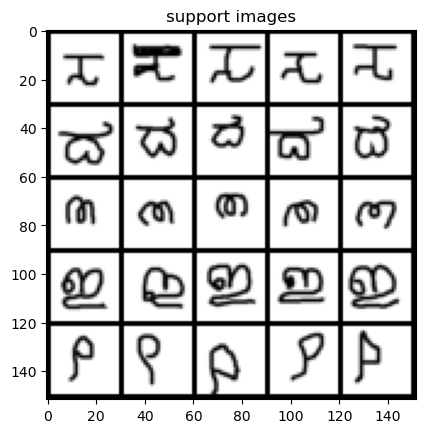

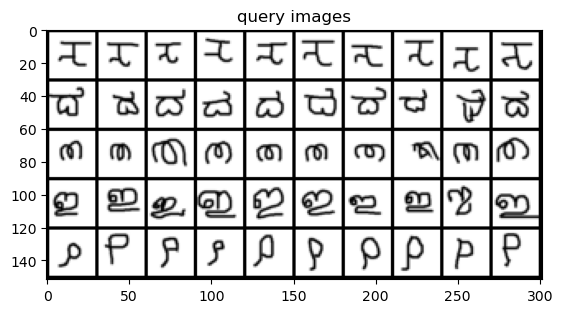

In [5]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader)) # 迭代器加载每一波数据

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

对于支持集和查询集，每个类都应该有一行。
我们的模型如何执行这项任务?

In [9]:
model.eval() # 模型设置为评估模式
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1) # 获取最大值

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Mongolian\character25 / Mongolian\character25
Kannada\character27 / Kannada\character27
Kannada\character27 / Mongolian\character25
Kannada\character27 / Kannada\character27
Kannada\character27 / Kannada\character27
Kannada\character27 / Kannada\character27
Kannada\character27 / Kannada\character27
Kannada\character27 / Kannada\character27
Kannada\character27 / Kannada\character27
Kannada\character27 / Old_Church_Slavonic_(Cyrillic)\character19
Kannada\character27 / Kannada\character27
Malayalam\character13 / Malayalam\character13
Malayalam\character13 / 

这看起来还不错:记住，模型是在非常不同的图像上训练的，每个类只看到了5个例子!
现在我们有了第一个想法，让我们更精确地看看我们的模型有多好。

In [12]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    返回查询标签的正确预测数，以及预测总数。
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # 最后我们会计算所有的东西并计算比率
    total_predictions = 0
    correct_predictions = 0

    # Eval模式影响某些层的行为(例如批处理规范化或dropout)
    # No_grad()告诉torch不要在内存中保存整个计算图(这样更轻量级)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [13]:
evaluate(test_loader)

100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Model tested on 100 tasks. Accuracy: 86.92%


在完全没有对Omniglot图像进行训练的情况下，每个类别只有5个示例，我们就达到了大约86%的准确率！这不是一个很好的开始吗？

现在你知道了如何使原型网络(Prototypical Networks)工作，你可以看看如果你稍微调整一下会发生什么（改变骨干网络，使用除了欧几里得距离之外的其他距离...）或者如果你改变问题（每个任务中的类别更多，支持集中的示例更少或更多，甚至只有一个示例，但请记住，在那种情况下，原型网络就是标准的最近邻）。

当你完成后，你可以继续向下滚动并学习如何**对这个模型进行元训练(meta-train)**，以获得更好的结果。

## 训练一个元学习算法

让我们使用Omniglot的“背景”图像作为训练集。这里我们准备了一个包含40,000个小样本分类任务的数据加载器，我们将在此基础上训练我们的模型。训练集中使用的字母表与测试集中使用的完全分开。这保证了在测试时，模型将不得不分类在训练期间未见过的字符。

注意，为了保持这个笔记本的简洁，我们这里没有设置验证集，但请记住，**这不是一个好习惯**，在训练生产模型时，你应该始终使用验证集。

In [14]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

我们将保持相同的模型。所以我们的权重将在ImageNet上预训练。如果你想从头开始训练，随意在ResNet的定义中设置`pretrained=False`。

这里我们定义了我们的损失和优化器（交叉熵和Adam，相当标准），以及一个`fit`方法。这个方法以一个分类任务为输入（支持集和查询集）。它根据支持集的信息预测查询集的标签；然后它将预测的标签与查询标签的真实值进行比较，这给了我们一个损失值。然后它使用这个损失来更新模型的参数。这是一个*元训练循环*。

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

训练模型，我们只需迭代执行大量随机生成的小样本分类任务，并让`fit`方法在每个任务后更新我们的模型。这被称为**情景训练**。

你不想训练的话，直接在最后加载预训练模型即可

In [18]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 18/40000 [00:19<11:47:56,  1.06s/it, loss=1.67]


KeyboardInterrupt: 

In [21]:
# 加载别人预训练好的模型直接查看结果
# !wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("weight/resnet18_with_pretraining.tar", map_location="cpu"))

<All keys matched successfully>

现在让我们看看我们的模型是否变得更好!

In [22]:
evaluate(test_loader)

100%|██████████| 100/100 [00:14<00:00,  6.99it/s]

Model tested on 100 tasks. Accuracy: 97.74%
